In [4]:
import numpy as np
import torch

# Buat data dummy
x = np.linspace(0, 10, 11)
y = np.linspace(0, 10, 11)
X, Y = np.meshgrid(x, y)
inputs = np.array([X.flatten(), Y.flatten()]).T
targets = X.flatten() + Y.flatten()

x_tensor = torch.tensor(inputs, dtype=torch.float32)
y_tensor = torch.tensor(targets, dtype=torch.float32)


In [8]:
import torch.nn as nn

class GaussianMF(nn.Module):
    def __init__(self, mean, sigma):
        super().__init__()
        self.mean = nn.Parameter(torch.tensor(float(mean), dtype=torch.float32))
        self.sigma = nn.Parameter(torch.tensor(float(sigma), dtype=torch.float32))

    def forward(self, x):
        return torch.exp(-0.5 * ((x - self.mean) / self.sigma) ** 2)



In [9]:
class ANFIS(nn.Module):
    def __init__(self, n_rules=4):
        super().__init__()
        self.n_rules = n_rules

        # Anggap 2 membership functions per input => 2x2 = 4 rules
        self.mf_x = nn.ModuleList([
            GaussianMF(2.5, 2),
            GaussianMF(7.5, 2)
        ])
        self.mf_y = nn.ModuleList([
            GaussianMF(2.5, 2),
            GaussianMF(7.5, 2)
        ])

        # Layer konsekuen: setiap rule punya a*x + b*y + c
        self.rule_weights = nn.Parameter(torch.rand(n_rules, 3))  # [a, b, c] untuk tiap rule

    def forward(self, x):
        x1 = x[:, 0]
        x2 = x[:, 1]

        # Fuzzifikasi
        mu_x = [mf(x1) for mf in self.mf_x]
        mu_y = [mf(x2) for mf in self.mf_y]

        # Hitung firing strength tiap kombinasi fuzzy rule
        rules = []
        for i in range(2):
            for j in range(2):
                rules.append(mu_x[i] * mu_y[j])  # firing strength dari rule ke-(2*i + j)

        firing_strength = torch.stack(rules, dim=1)  # shape = [batch_size, n_rules]

        # Normalisasi firing strength
        norm_strength = firing_strength / torch.sum(firing_strength, dim=1, keepdim=True)

        # Hitung output dari konsekuen (neural layer linear)
        consequent_output = []
        for i in range(self.n_rules):
            a, b, c = self.rule_weights[i]
            out = a * x1 + b * x2 + c
            consequent_output.append(out)

        consequent_output = torch.stack(consequent_output, dim=1)

        # Agregasi semua rule berdasarkan normalisasi
        output = torch.sum(norm_strength * consequent_output, dim=1)

        return output


In [10]:
model = ANFIS()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

for epoch in range(200):
    optimizer.zero_grad()
    y_pred = model(x_tensor)
    loss = loss_fn(y_pred, y_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")


Epoch 0: Loss = 19.8520
Epoch 20: Loss = 5.3352
Epoch 40: Loss = 1.7139
Epoch 60: Loss = 0.5714
Epoch 80: Loss = 0.2162
Epoch 100: Loss = 0.1154
Epoch 120: Loss = 0.0902
Epoch 140: Loss = 0.0813
Epoch 160: Loss = 0.0753
Epoch 180: Loss = 0.0700


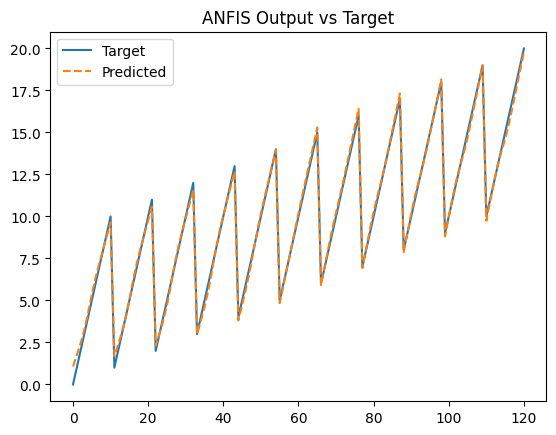

In [11]:
import matplotlib.pyplot as plt

pred = model(x_tensor).detach().numpy()
plt.plot(targets, label='Target')
plt.plot(pred, label='Predicted', linestyle='dashed')
plt.legend()
plt.title("ANFIS Output vs Target")
plt.show()
